### Install the beacon_api package to interact with the Beacon Data Lake API

You can find the package on PyPI: https://pypi.org/project/beacon-api/

If you run into any issues, please refer to the GitHub repository: https://github.com/maris-development/beacon

Documentation for the beacon_api package can be found here: https://maris-development.github.io/beacon-py/latest/

Documentation for the Beacon Data Lake technology can be found here: https://maris-development.github.io/beacon/


In [6]:
%pip install beacon-api --upgrade
from beacon_api import * # Import the Beacon API client
import os


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
BEACON_INSTANCE_URL = "https://beacon-wod.maris.nl"

#### Connect to the Beacon Data Lake


In [8]:
client = Client(BEACON_INSTANCE_URL)

Connected to: https://beacon-wod.maris.nl/ server successfully
Beacon Version: 1.5.2


#### List the available columns and their data types (e.g., string, integer) that can be queried.

In [36]:
available_columns = client.available_columns_with_data_type()
list(available_columns)[:50] # Display first 50 available columns

/var/folders/f1/w9sk77s91rv_drj5ydspy0dc0000gn/T/ipykernel_83861/1394025502.py:1: DeprecationWarning: Call to deprecated method available_columns_with_data_type. (Use list_tables() to get available tables. From there you can find the available columns and their data types for each table. This method will be removed in future versions.) -- Deprecated since version 1.1.0.
  available_columns = client.available_columns_with_data_type()


[pyarrow.Field<__entry_key: string>,
 pyarrow.Field<lat: float>,
 pyarrow.Field<lat.standard_name: string>,
 pyarrow.Field<lat.long_name: string>,
 pyarrow.Field<lat.lat_units: string>,
 pyarrow.Field<lon: float>,
 pyarrow.Field<lon.standard_name: string>,
 pyarrow.Field<lon.long_name: string>,
 pyarrow.Field<lon.lon_units: string>,
 pyarrow.Field<time: timestamp[ms]>,
 pyarrow.Field<time.standard_name: string>,
 pyarrow.Field<time.long_name: string>,
 pyarrow.Field<time.units: string>,
 pyarrow.Field<cast: int32>,
 pyarrow.Field<cast.comment: string>,
 pyarrow.Field<country: string>,
 pyarrow.Field<WOD_cruise_identifier: string>,
 pyarrow.Field<WOD_cruise_identifier.comment: string>,
 pyarrow.Field<WOD_cruise_identifier.long_name: string>,
 pyarrow.Field<originators_cruise_identifier: string>,
 pyarrow.Field<wod_unique_cast: int32>,
 pyarrow.Field<wod_unique_cast.cf_role: string>,
 pyarrow.Field<lat.units: string>,
 pyarrow.Field<lat.axis: string>,
 pyarrow.Field<lon.units: string>,
 

#### Build a query


In [ ]:
# Here we build the query step by step. First we select the columns we want to retrieve, then we add the filters and finally we specify the output format.
query_builder = client.query()

query_builder.add_select_column("wod_unique_cast") 
query_builder.add_select_column("Platform", alias="PLATFORM") 
query_builder.add_select_column("Institute", alias="INSTITUTE") 
query_builder.add_select_column("Temperature", alias="TEMPERATURE")
query_builder.add_select_column("Temperature_WODflag", alias="TEMPERATURE_QC")
query_builder.add_select_column("Temperature.units", alias="TEMPERATURE_UNIT")
query_builder.add_select_column("z", alias="DEPTH")
query_builder.add_select_column("z.units", alias="DEPTH_UNIT")
query_builder.add_select_column("time", alias="TIME") 
query_builder.add_select_column("lon", alias="LONGITUDE")
query_builder.add_select_column("lat", alias="LATITUDE")
query_builder.add_select_column(".featureType", alias="FEATURE_TYPE")

## Add the filters
query_builder.add_range_filter("TIME", "2022-01-01T00:00:00", "2023-01-01T00:00:00")  # You can adjust the date range as needed. The format is ISO 8601.
query_builder.add_is_not_null_filter("TEMPERATURE")  # Ensure Temperature is not null
query_builder.add_not_equals_filter("TEMPERATURE", -1e+10)  # Remove missing values as WOD netcdf files didn't specify missing value attribute which means we have to filter them out manually
query_builder.add_equals_filter("TEMPERATURE_QC", 0.0)  # Only good quality temperature
query_builder.add_range_filter("DEPTH", 0, 10)  # Depth range from 0 to 10 meters


df = query_builder.to_pandas_dataframe()
df

/var/folders/f1/w9sk77s91rv_drj5ydspy0dc0000gn/T/ipykernel_83861/4224498893.py:2: DeprecationWarning: Call to deprecated method query. (To query, use list_tables() or list_datasets() as a base to create a new query object. This method will be removed in future versions.)
  query_builder = client.query()


Creating JSONQuery with from: FromTable(table='default')
Running query: {"output": {"format": "parquet"}, "select": [{"column": "wod_unique_cast", "alias": null}, {"column": "Platform", "alias": "PLATFORM"}, {"column": "Institute", "alias": "INSTITUTE"}, {"column": "Temperature", "alias": "TEMPERATURE"}, {"column": "Temperature_WODflag", "alias": "TEMPERATURE_QC"}, {"column": "Temperature.units", "alias": "TEMPERATURE_UNIT"}, {"column": "z", "alias": "DEPTH"}, {"column": "z.units", "alias": "DEPTH_UNIT"}, {"column": "time", "alias": "TIME"}, {"column": "lon", "alias": "LONGITUDE"}, {"column": "lat", "alias": "LATITUDE"}, {"column": ".featureType", "alias": "FEATURE_TYPE"}], "filters": [{"column": "TIME", "gt_eq": "2022-01-01T00:00:00", "lt_eq": "2023-01-01T00:00:00"}, {"is_not_null": {"column": "TEMPERATURE"}}, {"column": "TEMPERATURE", "neq": -10000000000.0}, {"column": "TEMPERATURE_QC", "eq": 0.0}, {"column": "DEPTH", "gt_eq": 0, "lt_eq": 10}], "distinct": null, "sort_by": null, "lim

,wod_unique_cast,PLATFORM,INSTITUTE,TEMPERATURE,TEMPERATURE_QC,TEMPERATURE_UNIT,DEPTH,DEPTH_UNIT,TIME,LONGITUDE,LATITUDE,FEATURE_TYPE
0,21960131,None,None,13.860000,0,degree_C,0.000000,m,2022-09-30 16:09:59.999,-131.511993,52.104000,Profile
1,21960131,None,None,13.820000,0,degree_C,5.000000,m,2022-09-30 16:09:59.999,-131.511993,52.104000,Profile
2,21960145,None,None,29.250000,0,degree_C,4.000000,m,2022-09-30 19:59:00.002,-64.922997,17.313999,Profile
3,21960145,None,None,29.200001,0,degree_C,6.000000,m,2022-09-30 19:59:00.002,-64.922997,17.313999,Profile
4,21960145,None,None,29.120001,0,degree_C,9.000000,m,2022-09-30 19:59:00.002,-64.922997,17.313999,Profile
...,...,...,...,...,...,...,...,...,...,...,...,...
3519757,22703233,None,SCRIPPS INSTITUTION OF OCEANOGRAPHY; LA JOLLA; CA,14.135000,0,degree_C,8.929264,m,2022-12-28 05:37:30.000,-152.567169,-41.942951,Profile
3519758,22703233,None,SCRIPPS INSTITUTION OF OCEANOGRAPHY; LA JOLLA; CA,14.125000,0,degree_C,9.226898,m,2022-12-28 05:37:30.000,-152.567169,-41.942951,Profile
3519759,22703233,None,SCRIPPS INSTITUTION OF OCEANOGRAPHY; LA JOLLA; CA,14.124000,0,degree_C,9.425323,m,2022-12-28 05:37:30.000,-152.567169,-41.942951,Profile
3519760,22703233,None,SCRIPPS INSTITUTION OF OCEANOGRAPHY; LA JOLLA; CA,14.119000,0,degree_C,9.524534,m,2022-12-28 05:37:30.000,-152.567169,-41.942951,Profile


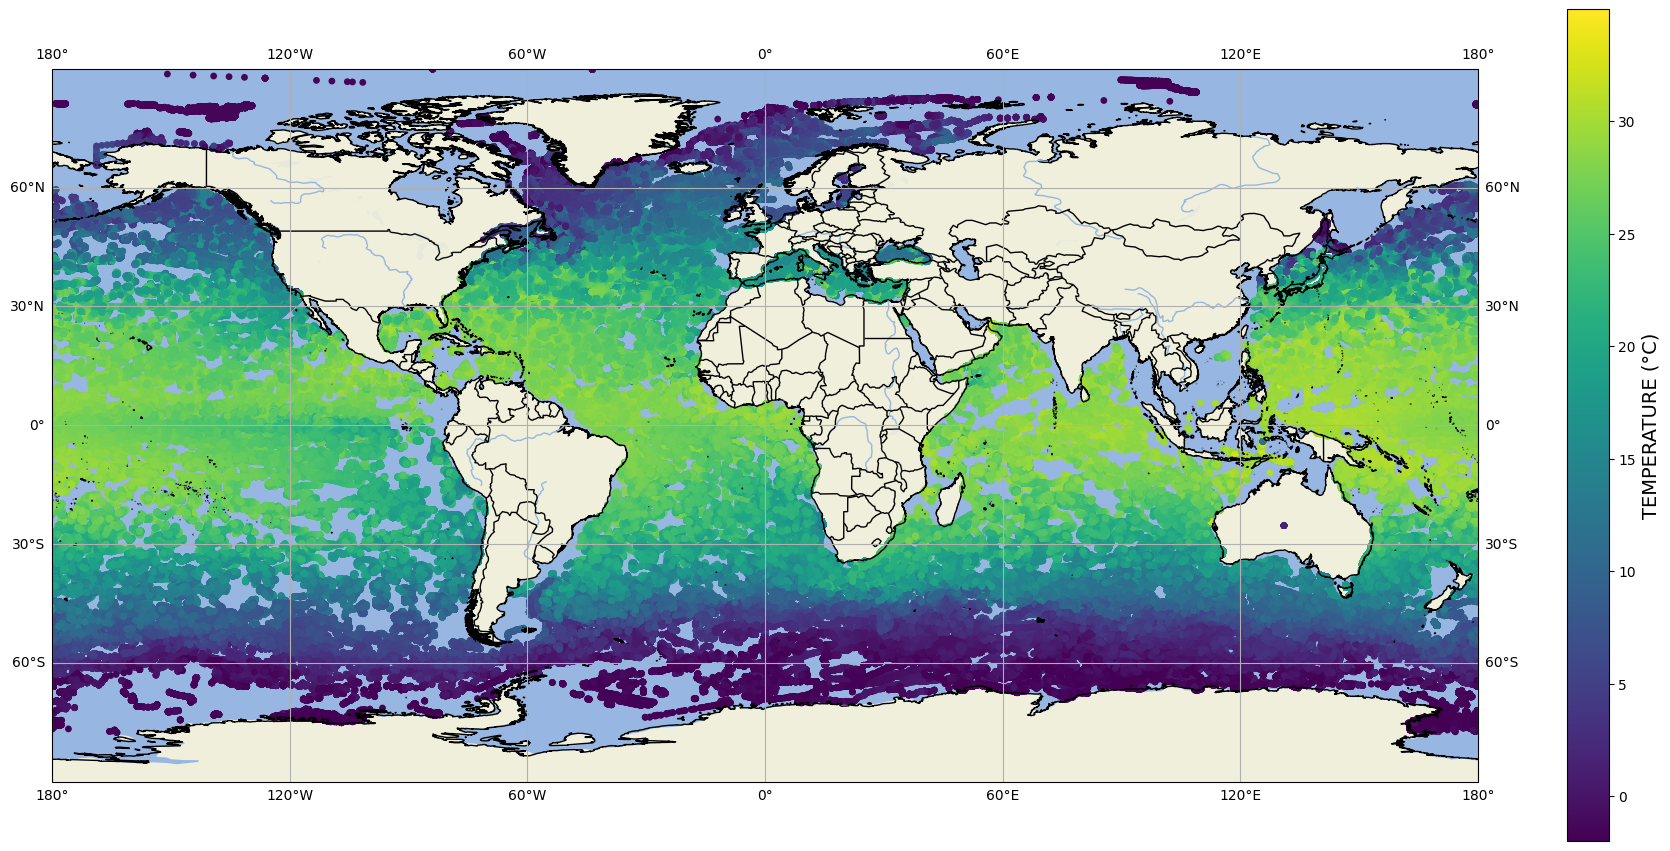

In [38]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(23, 18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # (west, east, south, north)

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df['TEMPERATURE'], cmap="viridis", s=15, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1) 

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, label="Value Set 1")
cbar.set_label(f"TEMPERATURE (°C)", fontsize=14)

plt.show()